In [1]:
import matplotlib as mpl
print('matplotlib: {}'.format(mpl.__version__))

matplotlib: 3.9.0


In [2]:
from aemulusnu_mf_lib.utils import *
from aemulusnu_mf_lib.massfunction import *
from aemulusnu_massfunction.emulator_training import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [3]:
cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()



from pyccl import lib

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()
print('alist', a_list)


alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459, 0.302679]


We'll model residual 
$$\frac{(N_{\rm true} - N_{\rm emulator,loo})} { N_{\rm true}} \sim \mathcal N\left(0, \frac{{\mathbf C}_{\rm jackknife}}{N_{\rm true}^2} + {\rm diag}(\sigma_{\rm mass-function}^2)\right)$$
Where we model $\sigma_{\rm mass-function}^2$ with 
$$\sigma_{\rm mass-function}(\sigma_M) = A+{\rm exp}\{B+C(\nu-3) + D*(a-0.5) \}$$
Where $\{A,B,C,D\}$ will be our free parametersr
```
A+10**(B + C * (nu-3) + D*(a-0.5))
```

In [4]:
sigMs_for_box = {}
jackknife_for_box = {}
jackknife_rescaled_for_box = {}
R_vecs_for_box = {}
Ms_for_box = {}
Ns_for_box = {}
weird_boxes = []
measured_N = {box:{a:{} for a in a_list} for box in cosmo_params if box not in weird_boxes} 
edges_for_box = {box:{a:{} for a in a_list} for box in cosmo_params if box not in weird_boxes} 

for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    if('n50' not in box):
        continue
    cosmo_vals = get_cosmo_vals(cosmo_params[box])
    ccl_cosmo = get_ccl_cosmology(tuple(cosmo_vals))
    
    ccl_cosmo['extra_parameters']['mirror_cosmo'] = ccl.Cosmology(Omega_c=ccl_cosmo['Omega_c'],
                                             Omega_b=ccl_cosmo['Omega_b'],
                                             h=ccl_cosmo['h'],
                                             A_s=ccl_cosmo['A_s'],
                                             n_s=ccl_cosmo['n_s'],
                                             w0=ccl_cosmo['w0'],
                                             m_nu=ccl_cosmo['m_nu'])
    funcType = type(ccl_cosmo['extra_parameters']['mirror_cosmo']._compute_linear_power)

    ccl_cosmo['extra_parameters']['mirror_cosmo']._compute_linear_power = MethodType(custom_compute_linear_power,
                                                                                     ccl_cosmo['extra_parameters']['mirror_cosmo'])
    ccl_cosmo['extra_parameters']['mirror_cosmo'].compute_sigma()

    NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
    NvM_f = open(NvM_fname, 'rb')
    NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
    NvM_f.close()
    Ms_for_box[box] = {a: NvMs[a]['M'] for a in a_list}
    Ns_for_box[box] = {a: NvMs[a]['N'] for a in a_list}

    sigMs = []
    plot_data = None

    for a in a_list:
        try:
            with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "rb") as f:
                plot_data = pickle.load(f)
        except:
            print('skipiping', box)
            continue
        model = plot_data['tinker_eval']
        true  = plot_data['N']
        edges = plot_data['edges']
        measured_N[box][a] = [true, edges]
        edges_for_box[box][a] = edges
        logM = np.log10(NvMs[a]['M'])
        status = 0
        sigM, status = lib.sigM_vec(ccl_cosmo['extra_parameters']['mirror_cosmo'].cosmo, a, logM,
                                        len(logM), status)
        sigMs += [sigM]

    sigMs_dict = {a:sigM for a,sigM in zip(a_list, sigMs)}
    sigMs_for_box[box] = sigMs_dict
    
    R_Vecs = []

        

    jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
    jackknife_covs_f = open(jackknife_covs_fname, 'rb')
    jackknife = pickle.load(jackknife_covs_f)
    jackknife_covs_f.close()
    jackknife_for_box[box] = {}
    jackknife_rescaled_for_box[box] = {}
    for a in a_list:
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "rb") as f:
            plot_data = pickle.load(f)
        model = plot_data['tinker_eval']
        true  = plot_data['N']
        edges = plot_data['edges']
        edgeslog10 = np.log10(edges)

        jack_cov = jackknife[a][1]
        jackknife_for_box[box][a] = jack_cov 
        jackknife_rescaled_for_box[box][a] = np.array([[jack_cov[i][j]/(NvMs[a]['N'][i] * NvMs[a]['N'][j]) 
                           for j in range(len(jack_cov))] 
                          for i in range(len(jack_cov))])
        
        assert(jack_cov.shape[0] == model.shape[0])
        assert(len(true) == len(model))
        assert(len(true) == len(edges)-1)

        R_Vec = []
        for ledge, redge, model_in_bin, true_in_bin in zip(edgeslog10, edgeslog10[1:], model, true):
            R_Vec += [(model_in_bin-true_in_bin)/true_in_bin]
        R_Vecs += [R_Vec]
    R_vecs_for_box[box]  = dict(zip(a_list, R_Vecs))
#     print(len(R_Vecs))

100%|██████████| 150/150 [03:08<00:00,  1.26s/it]


In [5]:
param_names = ['A', 'B', 'C', 'D']

def sigma_mass_function(A, B, C, D, box, a):
    nu  = 1.68647019984/sigMs_for_box[box][a] 
    return  A+10**(B + C * (nu-3) + D*(a-0.5))
    
    
def get_tot_cov(A, B, C, D, box, a):
    sigma_hmf_diag = sigma_mass_function(A, B, C, D, box, a) 
    return  jackknife_rescaled_for_box[box][a] + np.diag(np.square(sigma_hmf_diag))


def log_prob(param_values):   
    """    
    Args:
        param_valuesad
        
    Returns:
        float: Resulting log probability
    """
    params = dict(zip(param_names, param_values))
    if(params['A'] < 0):
        return -np.inf
    BIAS = 0
    tot_covs = [get_tot_cov(**params, box=box, a=a) for a in a_list for box in R_vecs_for_box]
    R_Vecs = [R_vecs_for_box[box][a] for a in a_list for box in R_vecs_for_box]
    inv_covs =  [np.linalg.inv(tot_cov) for tot_cov in tot_covs]
    scale_covs = [np.log(np.linalg.det(tot_cov)) for tot_cov in tot_covs]
    
    log_probs =  [-0.5 * (len(tot_cov[0])* np.log(2*np.pi) + 
                          np.dot(np.dot((np.array(R_Vec)).T, inv_cov), (np.array(R_Vec))) + 
                          scale_cov) for tot_cov, inv_cov, scale_cov, R_Vec in zip(tot_covs, 
                                                                                   inv_covs, 
                                                                                   scale_covs, 
                                                                                   R_Vecs)]
    
    if not np.isfinite(sum(log_probs)):
        return -np.inf
    return sum(log_probs)


In [6]:
guess = np.random.uniform(size=(4))
# print(log_prob(guess))

# guess=[0,0,0] 
# print('%.1e'%log_prob(guess))
guess = [0.00554, -12.577, 0.905,-0.0577]


In [7]:
nll = lambda *args: -log_prob(*args)
from scipy import optimize as optimize


result = optimize.minimize(nll, guess,  method='Nelder-Mead', options={
    'maxiter': len(guess)*10000
})

In [8]:
print(guess)
print(result)

[0.00554, -12.577, 0.905, -0.0577]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -35731.549322819745
             x: [ 5.242e-03 -1.332e+01  9.273e-01 -5.896e-02]
           nit: 76
          nfev: 142
 final_simplex: (array([[ 5.242e-03, -1.332e+01,  9.273e-01, -5.896e-02],
                       [ 5.242e-03, -1.332e+01,  9.273e-01, -5.896e-02],
                       ...,
                       [ 5.242e-03, -1.332e+01,  9.273e-01, -5.896e-02],
                       [ 5.242e-03, -1.332e+01,  9.273e-01, -5.896e-02]]), array([-3.573e+04, -3.573e+04, -3.573e+04, -3.573e+04,
                       -3.573e+04]))


In [9]:
best = result['x']
best_params = dict(zip(param_names, best))
print(best_params)

{'A': 0.005241843784097642, 'B': -13.315358160239178, 'C': 0.927293165168058, 'D': -0.05895928201845503}


In [10]:
print('%.1e'%log_prob(best))


3.6e+04


In [11]:
plt.show()

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 23


In [12]:
import seaborn as sns


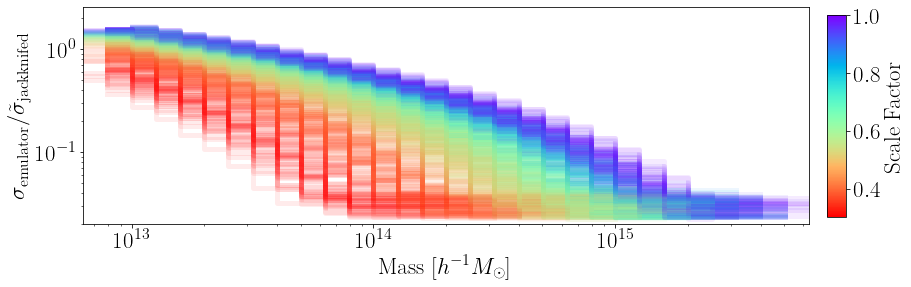

In [13]:
plt.figure(figsize=(13, 4), facecolor='w')
mn = 1e12
mx = 5e15


import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))
norm = mcolors.Normalize(vmin=min(a_list), vmax=max(a_list))
colormap = cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['rainbow_r'])
MN_BIN = np.inf
MX_BIN = 0


for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        plot_y = sigma_mass_function(**best_params, box=box, a=a)/np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a]))
        curr_edges = edges_for_box[box][a]
#         print(plot_y)
        plot_y = plot_y.tolist()

        plt.step(curr_edges, plot_y+[plot_y[-1]], where='post',linewidth=5, 
                color=colormap.to_rgba(a),alpha=0.08)
        MN_BIN = min(MN_BIN, min(curr_edges))
        MX_BIN = max(MX_BIN, max(curr_edges))

#         plt.plot(Ms_for_box[box][a], ,
#                 color=colormap.to_rgba(a), lw=5, alpha=0.08)

plt.xscale('log', base=10)
plt.yscale('log', base=10)
# plt.legend(frameon=False)
plt.xlim(MN_BIN, MX_BIN)
plt.ylim(2e-2, 2.6)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$\sigma_{\rm emulator} / \tilde\sigma_{\rm jackknifed}$')
# Add a colorbar
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar

plt.savefig('ratio_sigemulator_sigjackknife_tier2.pdf', bbox_inches='tight')
plt.savefig('ratio_sigemulator_sigjackknife_tier2.png', bbox_inches='tight')

In [14]:
best_params

{'A': 0.005241843784097642,
 'B': -13.315358160239178,
 'C': 0.927293165168058,
 'D': -0.05895928201845503}

In [15]:
rounded_params = {}
print(r'\{', end='')

for b in best_params:
    tmp = ('%.5g'%(best_params[b]))
#     print(tmp, eval(tmp))
    print(tmp, end=', ')
    rounded_params[b] = eval(tmp)
print(r'\}', end='')
 

\{0.0052418, -13.315, 0.92729, -0.058959, \}

In [16]:
# x = np.random.randn(10000, 3)



import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))

tot_covs = [get_tot_cov(**best_params, box=box, a=a) for a in a_list for box in R_vecs_for_box]
# tot_covs = [get_tot_cov(**rounded_params, box=box, a=a) for a in a_list for box in R_vecs_for_box]

R_Vecs = [np.array(R_vecs_for_box[box][a]) for a in a_list for box in R_vecs_for_box]


chi2s =  [np.dot(np.dot((np.array(R_vec) ).T, np.linalg.inv(tot_cov)), (np.array(R_vec) )) for R_vec, tot_cov in zip(R_Vecs, tot_covs)]
# Flatten the nested list
R_Vecs_flattened = np.concatenate([np.array(sublist).flatten() for sublist in R_Vecs])

# Get the total number of elements using np.ones_like
total_elements = np.sum(np.ones_like(R_Vecs_flattened))

dof = total_elements - 4


print(sum(chi2s)/dof)



0.9778404739982829


In [17]:
plt.show()
plt.rcParams['font.size'] = 11


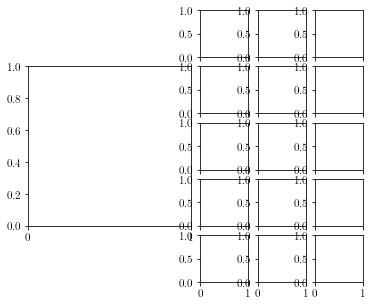

In [18]:
moasic = [
    ['.','.','.','a1','a2','a3'],
    ['H','H','H','a4','a5','a6'],
    ['H','H','H','a7','a8','a9'],
    ['H','H','H','a10','a11','a12'],
    ['.','.','.','a13','a14','a15'],
]
fig, axs= plt.subplot_mosaic(moasic, figsize=(6,5), sharex=True)

axs['H'].xaxis.set_tick_params(labelbottom=True)
plt.rcParams['font.size'] = 11


In [19]:

ax1 = axs['H']


x = [(R_Vec ) / np.sqrt(np.diagonal(tot_cov)) for R_Vec, tot_cov in zip(R_Vecs, tot_covs)]
print(len(x), len(a_list)*(50-1))

import matplotlib as mpl
import matplotlib.colors as mcolors

rainbow_list = []
for i, a in enumerate(a_list):
    for box in R_vecs_for_box:
        rainbow_list += [colormap.to_rgba(a)]
#         rainbow_list += ['red']

# Define your custom bins
bin_edges = np.arange(-4, 4.1, 0.5)  

# Plot original histogram using custom bin edges
n1, bins1, patches1 = ax1.hist(x, bins=bin_edges, density=True, histtype='bar', 
                               stacked=True, edgecolor='none', color=rainbow_list, rasterized=True) 

# Generate random samples from a normal distribution with mean=0 and variance=1
normal_data = np.random.normal(0, 1, 10000000)
# normal_data = np.random.normal(0, 1, 100)

# Plot histogram of normal distribution using the same custom bin edges
n2, bins2, patches2 = ax1.hist(normal_data, bins=bin_edges, density=True, histtype='step', 
                               linestyle='dashed', edgecolor='black', 
                               facecolor='none', label=r'$\mathcal N(0,1)$')
# Add labels and title
ax1.set_xlabel(r'$$\frac{(\hat N_{\rm loo} - N_{\rm true})/N_{\rm true}}{\sqrt{\sigma_{\log N_{\rm true}}^2  + \sigma_{\log N\mid{\rm mf}}^2}}$$')
# plt.ylabel('Density')
ax1.set_yticks([])
ax1.set_xticks([-3,0,3])

# plt.title('Histogram')

# Compute the chi2 metric between the two histograms
# chi2_metric = np.sum(((n1 - n2) ** 2) / (n1 + n2))

# plt.title(r'$\chi^2$: %.2f'%(chi2_metric))
ax1.text(.01, .99,
        s=r'\texttt{Dashed Line} shows $\mathcal N(0,1)$' + '\n' + r'$\chi^2/\texttt{dof}$=%.2f'%(sum(chi2s)/dof), 
        transform=ax1.transAxes,
        horizontalalignment='left',
        verticalalignment='top',
            c='black',
       fontsize=11)
# plt.text(.99, .99,
#         s=,
#         transform=plt.gca().transAxes,
#         horizontalalignment='right',
#         verticalalignment='top',
#             c='black',
#        fontsize=30)



# plt.legend(frameon=False)
ax1.set_ylim([0, 0.44])




# plt.savefig('hist_chi2_tier2.pdf', bbox_inches='tight')
# plt.savefig('hist_chi2_tier2.png', bbox_inches='tight')

750 735


(0.0, 0.44)

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax1)
cax = divider.append_axes('left', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')

cbar = ColorbarBase(cax, cmap=mpl.colormaps['rainbow_r'], norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')


In [21]:

z_list = list(map(scaleToRedshift, a_list))

# Define your custom bins
bin_edges = np.arange(-4, 4.1, 0.5)  
# fig2, ax2 = plt.subplots(nrows=5, ncols=3, figsize=(1.2 * 3, 6),  
#                         facecolor='w', sharex=True, sharey=True)
axs = [axs['a%d'%(i+1)] for i in range(15)]
for a,ax in zip(a_list, axs):    
    print(a)
    
    plt.rcParams['font.size'] = 11

    curr_tot_cov = [get_tot_cov(**best_params, box=box, a=a) for box in R_vecs_for_box]
    curr_R_Vecs = [np.array(R_vecs_for_box[box][a]) for box in R_vecs_for_box]


    curr_x = [(R_Vec ) / np.sqrt(np.diagonal(tot_cov)) for R_Vec, tot_cov in zip(curr_R_Vecs, curr_tot_cov)]

    num_resids = len([1 for a in curr_x for b in a])
    n1, bins1, patches1 = ax.hist(curr_x, bins=bin_edges, density=True, histtype='bar', stacked=True,
                                   edgecolor='none', rasterized=True, color = [colormap.to_rgba(a) for _ in range(len(curr_x))]) 

    n2, bins2, patches2 = ax.hist(normal_data, bins=bin_edges, density=True, histtype='step', 
                                   linestyle='dashed', edgecolor='black', 
                                   facecolor='none', label=r'$\mathcal N(0,1)$')
    # plt.ylabel('Density')
    ax.set_yticks([])
    ax.set_xticks([-3,0,3])

    # plt.title('Histogram')
    ax.text(.02, .98,
            s=r'$z$=%.2f'%(1/a-1), 
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',
                c='black',
           fontsize=9)
    ax.set_ylim([0, 0.55])

    
# for ax in axs[-5:]:
#     ax.set_xlabel(r'$$\frac{(\hat N_{\rm loo} - N_{\rm true})/N_{\rm true}}{\sqrt{\sigma_{\log N_{\rm true}}^2  + \sigma_{\log N\mid{\rm mf}}^2}}$$')

    
# plt.savefig('hist_chi2_tier2_all.pdf', bbox_inches='tight')
# plt.savefig('hist_chi2_tier2_all.png', bbox_inches='tight')

1.0
0.953321
0.866399
0.787402
0.715608
0.65036
0.620002
0.591061
0.563471
0.537169
0.512095
0.488191
0.403224
0.366459
0.302679


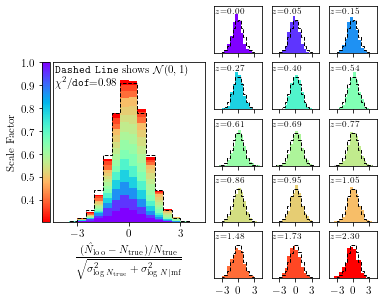

In [22]:
fig

In [23]:
fig.savefig('hist_chi2_tier2.pdf', bbox_inches='tight', dpi=300)
fig.savefig('hist_chi2_tier2.png', bbox_inches='tight', dpi=300)

In [24]:
# x = np.random.randn(10000, 3)



import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))


# tot_covs = [get_tot_cov(**best_params, box=box, a=a) for a in a_list for box in R_vecs_for_box]
tot_covs = [jackknife_rescaled_for_box[box][a] for a in a_list for box in R_vecs_for_box]

R_Vecs = [R_vecs_for_box[box][a] for a in a_list for box in R_vecs_for_box]


chi2s =  [np.dot(np.dot(np.array(R_vec).T, np.linalg.inv(tot_cov)), R_vec) for R_vec, tot_cov in zip(R_Vecs, tot_covs)]
# Flatten the nested list
R_Vecs_flattened = np.concatenate([np.array(sublist).flatten() for sublist in R_Vecs])

# Get the total number of elements using np.ones_like
total_elements = np.sum(np.ones_like(R_Vecs_flattened))

dof = total_elements 


print(sum(chi2s)/dof)



1.6384176202364933


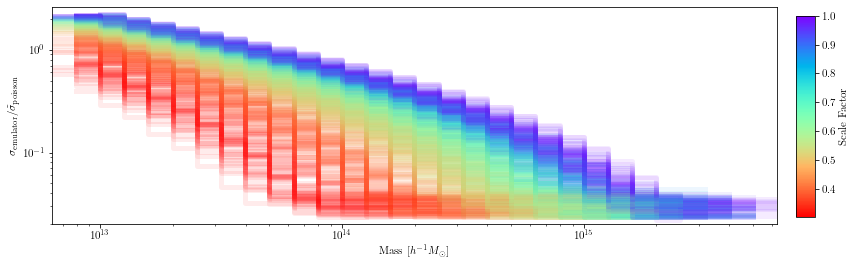

In [25]:
plt.figure(figsize=(13, 4), facecolor='w')
mn = 1e12
mx = 5e15


import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

MN_BIN = np.inf
MX_BIN = 0


z_list = list(map(scaleToRedshift, a_list))

for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        plot_y = sigma_mass_function(**best_params, box=box, a=a)/(1/np.sqrt(Ns_for_box[box][a]))
        curr_edges = edges_for_box[box][a]

        plot_y = plot_y.tolist()
        MN_BIN = min(MN_BIN, min(curr_edges))
        MX_BIN = max(MX_BIN, max(curr_edges))

        plt.step(curr_edges, plot_y+[plot_y[-1]], where='post',linewidth=5, 
                color=colormap.to_rgba(a),alpha=0.08)

#         plt.plot(Ms_for_box[box][a], ,
#                 color=colormap.to_rgba(a), lw=5, alpha=0.08)

plt.xscale('log', base=10)
plt.yscale('log', base=10)
# plt.legend(frameon=False)
plt.xlim(MN_BIN, MX_BIN)
plt.ylim(2e-2, 2.6)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$\sigma_{\rm emulator} / \tilde\sigma_{\rm poisson}$')
# Add a colorbar
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar

plt.savefig('ratio_sigemulator_sigpoisson_tier2.pdf', bbox_inches='tight')
plt.savefig('ratio_sigemulator_sigpoisson_tier2.png', bbox_inches='tight')

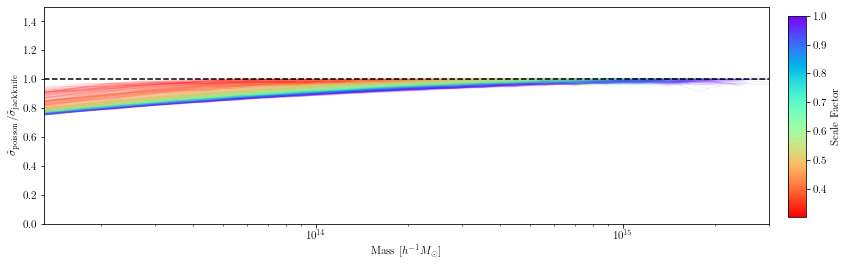

In [26]:
plt.figure(figsize=(13, 4), facecolor='w')
mn = 1e12
mx = 5e15


import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))

for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        plt.plot(Ms_for_box[box][a], (1/np.sqrt(Ns_for_box[box][a]))/np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a])),
                color=colormap.to_rgba(a), lw=1, alpha=0.08)

plt.xscale('log', base=10)
# plt.yscale('log', base=10)
# plt.legend(frameon=False)
plt.xlim(1.3e13, 3e15)
plt.ylim(0, 1.5)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$\tilde\sigma_{\rm poisson} / \tilde\sigma_{\rm jackknife}$')
plt.axhline(1, color='k', linestyle='--')
# Add a colorbar
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar

plt.savefig('ratio_sigpoisson_sigjackknife_tier2.pdf', bbox_inches='tight')
plt.savefig('ratio_sigpoisson_sigjackknife_tier2.png', bbox_inches='tight')

/tmp/ipykernel_6443/3472532199.py:14: RuntimeWarning: invalid value encountered in sqrt
  sample_var_est = (np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a])- (1/(Ns_for_box[box][a]))))


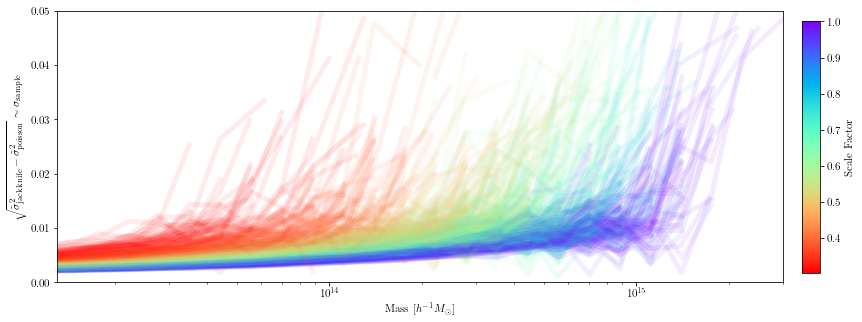

In [27]:
plt.figure(figsize=(13, 5), facecolor='w')
mn = 1e12
mx = 5e15


import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))

for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        sample_var_est = (np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a])- (1/(Ns_for_box[box][a]))))
        plt.plot(Ms_for_box[box][a], sample_var_est,
                color=colormap.to_rgba(a), lw=5, alpha=0.08)

plt.xscale('log', base=10)
# plt.yscale('log', base=10)
# plt.legend(frameon=False)
plt.xlim(1.3e13, 3e15)
plt.ylim(0, 5e-2)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$ \sqrt{\tilde\sigma_{\rm jackknife}^2 - \tilde\sigma_{\rm poisson}^2} \sim \sigma_{\rm sample}$')
# plt.axhline(1, color='k', linestyle='--')
# Add a colorbar
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar

plt.savefig('sig_sample_tier2.png', bbox_inches='tight')

/tmp/ipykernel_6443/3214740036.py:14: RuntimeWarning: invalid value encountered in sqrt
  sample_var_est = np.abs(np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a])


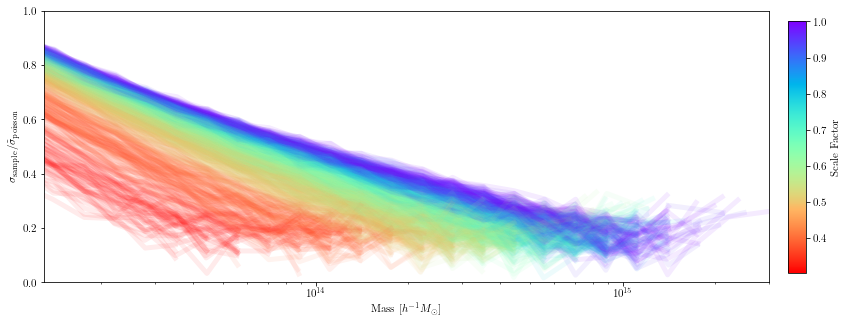

In [28]:
plt.figure(figsize=(13, 5), facecolor='w')
mn = 1e12
mx = 5e15


import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))

for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        sample_var_est = np.abs(np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a])
                                        - (1/(Ns_for_box[box][a]))))
        plt.plot(Ms_for_box[box][a], sample_var_est/(1/np.sqrt(Ns_for_box[box][a])),
                color=colormap.to_rgba(a), lw=5, alpha=0.08)

plt.xscale('log', base=10)
# plt.yscale('log', base=10)
# plt.legend(frameon=False)
plt.xlim(1.3e13, 3e15)
plt.ylim(0, 1)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$\sigma_{\rm sample}/\tilde \sigma_{\rm poisson}$')
# plt.axhline(1, color='k', linestyle='--')
# Add a colorbar
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar

plt.savefig('ratio_sigsample_sigpoisson_tier2.png', bbox_inches='tight')


In [29]:
emulator = AemulusNu_HMF_Emulator(emulator_loc = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_loBox0_1400.pkl')


loading emulator from /oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_loBox0_1400.pkl


In [30]:
#all for DES Y1
#Table 5. of Melchior
_Ωs = 1514 #[deg ^ 2]
def σ2SN_times_N(M, z,
                _A = 0.7e22,  #[h^-1 M_sol]^(3/2)
                _n0 = 6.3, #[arcmin^-2]
                _zs = 0.5
                ):
    return _A * M**(1/2) * 6.3/_n0 * np.exp(1/2 * z**2 / _zs**2)

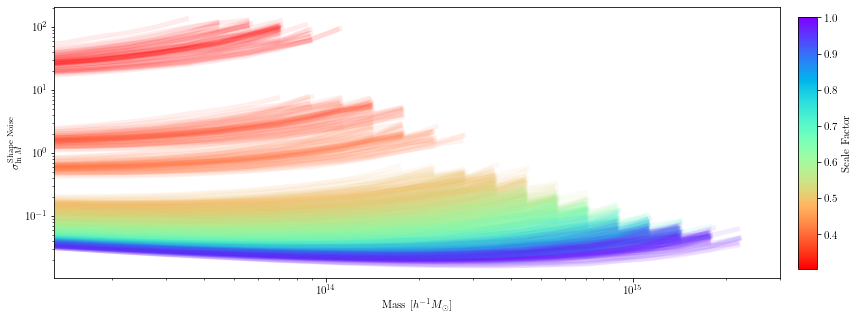

In [31]:
plt.figure(figsize=(13, 5))

norm = mcolors.Normalize(vmin=min(a_list), vmax=max(a_list))

colormap = cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['rainbow_r'])

for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
#         if(z != z_list[5]):
#             continue
        shape_noise_var = σ2SN_times_N(np.array(Ms_for_box[box][a])[:-1], z) / Ns_for_box[box][a][:-1]
        ln_shape_noise_var = shape_noise_var / np.array(Ms_for_box[box][a][:-1])**2
        plt.plot(Ms_for_box[box][a][:-1], np.sqrt(ln_shape_noise_var),
                color=colormap.to_rgba(a), lw=5, alpha=0.08)
#     break
plt.xlim(1.3e13, 3e15)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$\sigma^{\rm Shape\ Noise}_{\ln M}$')

plt.yscale('log')
plt.xscale('log')


cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar


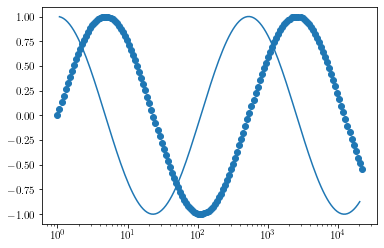

In [32]:
def get_deriv_log_spaced(f, x):
    #assume x is log separated
    logx = np.log(x)
    delta_logx = np.mean(np.diff(logx)) * 1e-2
    dfdlogx = (f(np.exp(logx[1:-1] + delta_logx)) - f(np.exp(logx[1:-1] - delta_logx))) / (2 * delta_logx)
    f_dfdlogx = interp1d(x[1:-1], dfdlogx, kind='cubic')
    f_df_dx = lambda x: f_dfdlogx(x) / x
    return f_df_dx
    
    
ffunny = lambda x: np.sin(np.log(x))
X_tmp = np.exp(np.linspace(0,10, 150))
plt.scatter(X_tmp, ffunny(X_tmp))

fdfdx = get_deriv_log_spaced(ffunny, X_tmp)
plt.xscale('log')
plt.plot(X_tmp[1:-1], fdfdx(X_tmp[1:-1]) * X_tmp[1:-1])

In [33]:





d2lnNdlnM2s = {}
for box in tqdm(jackknife_rescaled_for_box):
    M = 10**np.linspace(11, 16, 150)
    cosmo_vals = get_cosmo_vals(cosmo_params[box])
    ccl_cosmo = get_ccl_cosmology(tuple(cosmo_vals))
    h = cosmo_params[box]['H0']/100
    d2lnNdlnM2s[box] = {}
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        dndM = emulator(ccl_cosmo, M/h, a) /(h**3 * M * np.log(10))
        f_dndM   = interp1d(M, dndM, kind='cubic')
        f_d2ndM2 = get_deriv_log_spaced(f_dndM, M)
                
        
        curr_M = np.array(Ms_for_box[box][a])
        curr_N = np.array(Ns_for_box[box][a])
        
        d2lnNdlnM2 = f_dndM(curr_M) * 1050**3 / curr_N
        d2lnNdlnM2 -= curr_M * (f_dndM(curr_M) * 1050**3 / curr_N)**2
        d2lnNdlnM2 += curr_M / curr_N * f_d2ndM2(curr_M) * 1050**3
        d2lnNdlnM2 *= curr_M  
        d2lnNdlnM2s[box][a] = d2lnNdlnM2

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


In [34]:
NOISE_CHARACTER = [
#     { "_A" : 0.7e22,  #[h^-1 M_sol]^(3/2)
#                 "_n0" : 6.3, #[arcmin^-2]
#                 "_zs" : 0.5},
    { "_A" : 0.7e22,  #[h^-1 M_sol]^(3/2)
                "_n0" : 8.4, #[arcmin^-2]
                "_zs" : 0.6},
    { "_A" : 0.7e22,  #[h^-1 M_sol]^(3/2)
                "_n0" : 10, #[arcmin^-2]
                "_zs" : 0.85},
    { "_A" : 0.7e22,  #[h^-1 M_sol]^(3/2)
            "_n0" : 27, #[arcmin^-2]
            "_zs" : 0.85}

]


Mass calibration Ill approximate as only shape noise

In [35]:
plt.show()

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 11


100%|██████████| 50/50 [00:01<00:00, 45.02it/s]


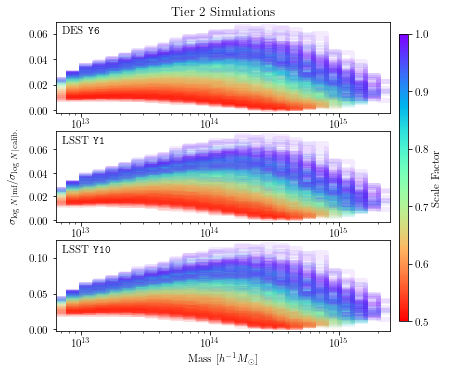

In [36]:
# plt.figure(figsize=(13, 5))

from scipy.interpolate import interp1d



NAME = [r'DES \texttt{Y6}', r'LSST \texttt{Y1}', r'LSST \texttt{Y10}']
norm = mcolors.Normalize(vmin=0.5, vmax=1)
colormap = cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['rainbow_r'])




# fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(6, 5.7))
# met_ax = fig.gca()
# plt.subplots_adjust(wspace=0, hspace=0)
fig = plt.figure(figsize=(6,5.7))
meta_ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313, sharex=ax1)

axs = [ax1, ax2, ax3]

# Turn off axis lines and ticks of the big subplot
meta_ax.spines['top'].set_color('none')
meta_ax.spines['bottom'].set_color('none')
meta_ax.spines['left'].set_color('none')
meta_ax.spines['right'].set_color('none')
meta_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

meta_ax.set_ylabel(r'$\sigma_{\log N \mid {\rm mf}} / \sigma_{\log N \mid {\rm calib.}}$'+'\n')

MN_BIN = np.inf
MX_BIN = 0
for ax_idx, ax in enumerate(axs):
    for box in tqdm(jackknife_rescaled_for_box):
        M = 10**np.linspace(11, 16, 150)
        cosmo_vals = get_cosmo_vals(cosmo_params[box])
        ccl_cosmo = get_ccl_cosmology(tuple(cosmo_vals))
        h = cosmo_params[box]['H0']/100

        for i, (a, z) in enumerate(zip(a_list, z_list)):
            if(z>=1):
                continue
#             print(np.log10(np.min(Ms_for_box[box][a])))
            shape_noise_var = σ2SN_times_N(np.array(Ms_for_box[box][a]), z, **NOISE_CHARACTER[ax_idx]) / Ns_for_box[box][a]
            ln_shape_noise_var =  shape_noise_var / np.array(Ms_for_box[box][a])**2
    #         print(d2lnNdlnM2s[box][a])
            ln_N_var_from_shape_noise = (0.1 * np.log(10) * d2lnNdlnM2s[box][a])**2 * (ln_shape_noise_var)
            ln_N_err_from_shape_noise = np.sqrt(ln_N_var_from_shape_noise)
            ln_N_err_from_hmf = sigma_mass_function(**best_params, box=box, a=a)
            plot_y = ln_N_err_from_hmf[:-1]/ln_N_err_from_shape_noise[:-1]
            curr_edges = edges_for_box[box][a][:-1]
            plot_y = plot_y.tolist()
            MN_BIN = min(MN_BIN, min(curr_edges))
            MX_BIN = max(MX_BIN, max(curr_edges))

#             print(len(curr_edges))
#             print(len(Ms_for_box[box][a]))
#             print(len(plot_y))
#             print()
#             ax.plot(Ms_for_box[box][a][:-1], plot_y,
#                     color=colormap.to_rgba(a), lw=13, alpha=0.08)
    
            ax.step(curr_edges, plot_y+[plot_y[-1]], where='post',linewidth=5, 
                    color=colormap.to_rgba(a),alpha=0.08)
        
#     break
    ax.set_xlim(MN_BIN, MX_BIN)
#     if(ax_idx != 3):
#         ax.set_ylim([0.0, 0.8])
#         ax.set_yticks([0, 0.05])
#     else:
#         ax.set_ylim([0.0, 0.12])
#         ax.set_yticks([0, 0.05])
#     ax.axhline(0.05, color='lightgrey', linestyle='--')
#     ax.set_ylabel(r'$\sigma_{\rm emulator} / \sigma_{\rm mass\ calibration}$')
    ax.text(.02, .95,
            s= NAME[ax_idx],
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',
            c='black',
           fontsize=11)
    ax.set_xscale('log')

#     ax.fill_between([0, 1e16], [0.1, 0.1], [1,1], color='lightgrey')
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
# plt.yscale('log')

axs[0].set_title('Tier 2 Simulations')
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar


plt.savefig('ratio_sigemu_sigShapeNoise_tier2.pdf', bbox_inches='tight')